In [1]:
# push!(LOAD_PATH, "/Users/kyle/Documents/SCHOOL/Stanford/Research/RoboRace/workspace/src")
using AutomotiveDrivingModels
using Reactive
using AutoViz
using Interpolations
# using SplineUtils

import PyPlot

/Users/kyle/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [12]:
function ClosedB_Spline(Pts, degree, L_tt) # returns spline and derivative of spline
    k = degree
    p = k - 1 # degree of derivative
    n = size(Pts,2) # number of control points
    m = n + k + 1; # number of knots in T
    
    #knots
    T = 0.5*ones(m,1)
    T[1:k] = 0
    T[(k+1):end-(k)] = linspace(0,1,m-2*k)
    T[end-(k):end] = 1.0
    
    tt = linspace(0,1,L_tt)
    rx = zeros(size(tt))
    ry = zeros(size(tt))
    
#     Q = zeros(size(Pts[:,1:end-1]))
#     ṙx = zeros(size(tt)) # derivatives
#     ṙy = zeros(size(tt)) # derivatives

    invd = Dict() # inverse denominator (to deal with zero denominators)
    for i = 1:k+1
        invd[i] = T[(i+1):end] - T[1:(end-(i))]
        # take care of empty knot spans
        for j = 1:size(invd[i])[1]
            if invd[i][j] != 0
                invd[i][j] = 1.0/invd[i][j]
            end
        end
    end
    
    # Derivative
#     Q[1,:] = p*invd[1][p+1:end-p].*(Pts[1,2:end] - Pts[1,1:end-1])
#     Q[2,:] = p*invd[1][p+1:end-p].*(Pts[2,2:end] - Pts[2,1:end-1])
    
    N = Dict()
    for j = 1:size(tt)[1]
        t = tt[j]
        N[1] = 1.0*(t .>= T[1:end-1]) .* (t .< T[2:end])

        for i = 1:k+1
            if i > 1
                N[i] = (t - T[1:end-i]) .* (invd[i-1].*N[i-1])[1:end-1] + (T[i+1:end] - t) .*(invd[i-1].*N[i-1])[2:end]
            end
        end
        
        rx[j] = (Pts[1,:]'*N[k+1])[1]
        ry[j] = (Pts[2,:]'*N[k+1])[1]
        
#         ṙx[j] = (Q[1,:]'*N[k][2:end-1])[1] # derivatives
#         ṙy[j] = (Q[2,:]'*N[k][2:end-1])[1] # derivatives
    end
    
    rx[end] = Pts[1,end]
    ry[end] = Pts[2,end] 
    
    return T, tt, rx, ry
end

ClosedB_Spline (generic function with 1 method)

In [3]:
function B_SplineDerivative(T, # knots
    tt, # sample locations t ∈ [0,1.0]
    Pts, # control points
    k) # degree of spline

    p = k - 1 # degree of derivative
    n = size(Pts,2) # number of control points
    m = n + k + 1; # number of knots in T
    
#     Q = zeros(size(Pts[:,1:end-1]))
#     ṙx = zeros(size(tt)) # derivatives
#     ṙy = zeros(size(tt)) # derivatives
    
    invd = Dict() # inverse denominator (to deal with zero denominators)
    for i = 1:k+1
        invd[i] = T[(i+1):end] - T[1:(end-(i))]
        # take care of empty knot spans
        for j = 1:size(invd[i])[1]
            if invd[i][j] != 0
                invd[i][j] = 1.0/invd[i][j]
            end
        end
    end
    
    Q = zeros(size(Pts[:,1:end-1]))
    ṙx = zeros(size(tt)) # derivatives
    ṙy = zeros(size(tt)) # derivatives
    
    # Derivative
    Q[1,:] = p*invd[1][p+1:end-p].*(Pts[1,2:end] - Pts[1,1:end-1])
    Q[2,:] = p*invd[1][p+1:end-p].*(Pts[2,2:end] - Pts[2,1:end-1])
    
    N = Dict()
    for j = 1:size(tt)[1]
        t = tt[j]
        N[1] = 1.0*(t .>= T[1:end-1]) .* (t .< T[2:end])
        for i = 1:k+1
            if i > 1
                N[i] = (t - T[1:end-i]) .* (invd[i-1].*N[i-1])[1:end-1] + (T[i+1:end] - t) .*(invd[i-1].*N[i-1])[2:end]
            end
        end
        
        ṙx[j] = (Q[1,:]'*N[k][2:end-1])[1] # derivatives
        ṙy[j] = (Q[2,:]'*N[k][2:end-1])[1] # derivatives
    end
    
    ṙx[1] = ṙx[2]
    ṙx[end] = ṙx[end-1]
    ṙy[1] = ṙy[2]
    ṙy[end] = ṙy[end-1]
    
    return ṙx, ṙy
end

B_SplineDerivative (generic function with 1 method)

In [4]:
function PlotSplineRoadway(x,y,θ,lane_width)
    perp_lines1 = zeros(2,length(x))
    perp_lines2 = zeros(2,length(x))
    
    perp_lines1[1,:] = x + (lane_width/2.0)*sin(θ)
    perp_lines1[2,:] = y - (lane_width/2.0)*cos(θ)
    perp_lines2[1,:] = x - (lane_width/2.0)*sin(θ)
    perp_lines2[2,:] = y + (lane_width/2.0)*cos(θ)
    
    PyPlot.figure()
#     PyPlot.scatter(Pts[1,:],Pts[2,:],color="red")
    PyPlot.scatter(x,y)
    PyPlot.plot(x,y)
    PyPlot.plot(perp_lines1[1,:],perp_lines1[2,:],color="green")
    PyPlot.plot(perp_lines2[1,:],perp_lines2[2,:],color="green")
    PyPlot.axis("equal")
    PyPlot.show()
end

PlotSplineRoadway (generic function with 1 method)

In [48]:
function ResampleSplineEven(rx,ry,θ,s,k,num_samples)
    """
    Evenly resamples spline at num_samples points along arc_length
    
    """
    s_span = linspace(0,s[end],num_samples+1)
    xP = zeros(num_samples)
    yP = zeros(num_samples)
    sP = zeros(num_samples)
    θP = zeros(num_samples)
    kP = zeros(num_samples)
    
    xP[1] = rx[1]
#     xP[end] = rx[end]
    yP[1] = ry[1]
#     yP[end] = ry[end]
    θP[1] = θ[1]
#     θP[end] = θ[end]
    sP[1] = s[1]
#     sP[end] = s[end]
    kP[1] = k[1]
#     kP[end] = k[end]

    j = 1
    for t in 2:length(s)
        if j > num_samples
            break
        end
        if (s[t] > s_span[j]) && (s[t-1] <= s_span[j])
            sP[j] = s_span[j]
            xP[j] = rx[t-1] + (rx[t] - rx[t-1])*(s_span[j] - s[t-1]) / (s[t] - s[t-1])
            yP[j] = ry[t-1] + (ry[t] - ry[t-1])*(s_span[j] - s[t-1]) / (s[t] - s[t-1])
            θP[j] = θ[t-1] + (θ[t] - θ[t-1])*(s_span[j] - s[t-1]) / (s[t] - s[t-1])
            kP[j] = k[t-1] + (k[t] - k[t-1])*(s_span[j] - s[t-1]) / (s[t] - s[t-1])
            j += 1
        end
    end
    
    return xP, yP, θP, sP, kP
end

ResampleSplineEven (generic function with 1 method)

In [39]:
function GenSplineRoadway(x,y,θ,s,k,lane_width)
    nlanes = 1
    seg1 = RoadSegment(1, Array(Lane, nlanes))
    tag1=LaneTag(1,1)
    boundary_left = LaneBoundary(:solid, :white)
    boundary_right = LaneBoundary(:solid, :white)

    curvepts = Array(CurvePt, length(x))
    for i in 1:length(x)
        curvepts[i] = CurvePt(VecSE2(x[i],y[i],θ[i]), s[i], k[i], NaN)
    end

    curveind_lo = CurveIndex(1,0.0)
    curveind_hi = CurveIndex(length(curvepts)-1,1.0)

    seg1.lanes[1] = Lane(tag1, curvepts, width=lane_width,
                                  boundary_left=boundary_left, boundary_right=boundary_right,
                                  next = RoadIndex(curveind_lo, tag1),
                                  prev = RoadIndex(curveind_hi, tag1),
                                 )
    
    roadway = Roadway()
    push!(roadway.segments, seg1)
    
    return roadway
end

GenSplineRoadway (generic function with 1 method)

### Demo

In [49]:
# control points
Pts = 30*[0 -1 -2 -3 -3 -3 -2 -1 -1 -1 -2 -3 -4 -5 -5 -5 -5 -5 -5 -4 -3 -2 -1 -1 -1 0 1 1 1 2 3 4 5 5 5 5 5 5 5 4 3 3 3 3 2 1 0; 
        0 0 0 0 -1 -2 -2 -2 -3 -4 -4 -4 -4 -4 -3 -2 -1 0 1 2 3 4 4 3 2 2 2 3 4 4 4 4 3 2 1 0 -1 -2 -3 -4 -3 -2 -1 0 0 0 0]

degree = 3 # degree of spline
num_points = 10001

# compute B spline
T, tt, rx, ry = ClosedB_Spline(Pts, degree, num_points)
T;

In [50]:
# compute B spline derivative
ṙx, ṙy = B_SplineDerivative(T,tt,Pts,degree);

In [51]:
# compute theta 
θ = atan2(ṙy,ṙx) # unit tangent vector
# compute arc length s
s = zeros(size(rx))
s[2:end] = cumsum(sqrt(diff(rx).^2 + diff(ry).^2))
# compute curvature
k = diff(θ)./diff(s) # curvature
R = 1./k # radius of curvature
R;

In [52]:
# resample spline based on arc length
num_samples = 420
xP, yP, θP, sP, kP = ResampleSplineEven(rx,ry,θ,s,k,num_samples);
xP;

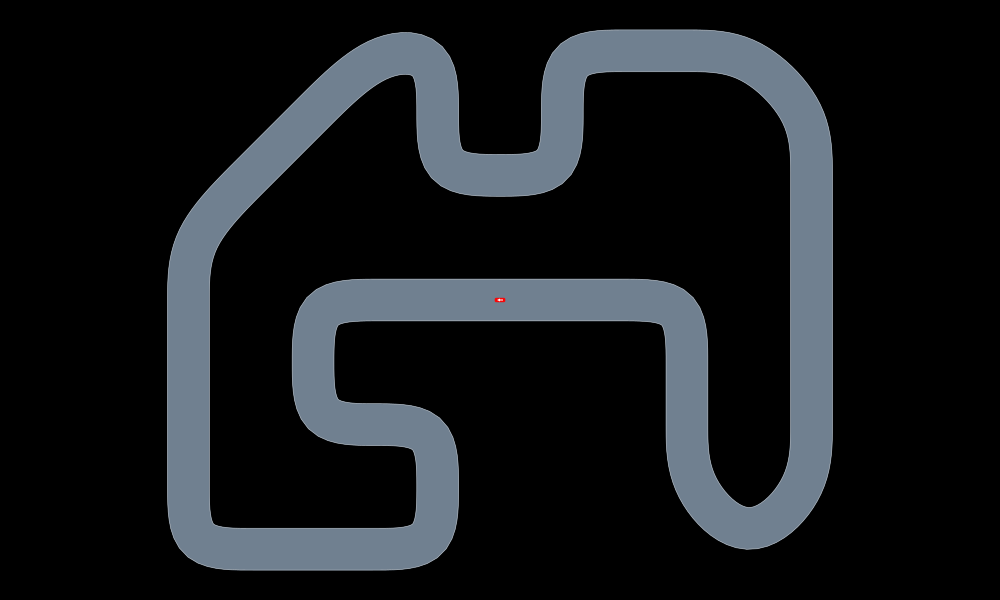

In [53]:
lane_width = 20.0

roadway = GenSplineRoadway(xP,yP,θP,sP,kP,lane_width)
scene = Scene()

roadind1 = RoadIndex(proj(VecSE2(0.0,-1*DEFAULT_LANE_WIDTH,0.0), roadway))
vehstate1 = VehicleState(Frenet(roadind1, roadway), roadway, 0.0)
vehdef1 = VehicleDef(1,AgentClass.CAR, 4.8, 1.8)
push!(scene,Vehicle(vehstate1, vehdef1))

carcolors = Dict{Int, Colorant}()
carcolors[1]=colorant"red"

render(scene, roadway, cam=FitToContentCamera(), car_colors=carcolors)

In [45]:
# Visualize roadway with PyPlot
# PlotSplineRoadway(xP,yP,θP,lane_width)
# PyPlot.scatter(Pts[1,:],Pts[2,:],color="red")
# PyPlot.show()

In [33]:
s_span = linspace(0,s[end],num_samples)
xP = zeros(num_samples)
yP = zeros(num_samples)
sP = zeros(num_samples)
θP = zeros(num_samples)
kP = zeros(num_samples)
s_span;

In [34]:
xP[1] = rx[1]
xP[end] = rx[end]
yP[1] = ry[1]
yP[end] = ry[end]
θP[1] = θ[1]
θP[end] = θ[end]
sP[1] = s[1]
sP[end] = s[end]
kP[1] = k[1]
kP[end] = k[end]

0.0

In [35]:
j = 1
for t in 2:length(s)
    if j > num_samples
        break
    end
    if (s[t] > s_span[j]) && (s[t-1] <= s_span[j])
        sP[j] = s_span[j]
        xP[j] = rx[t-1] + (rx[t] - rx[t-1])*(s_span[j] - s[t-1]) / (s[t] - s[t-1])
        yP[j] = ry[t-1] + (ry[t] - ry[t-1])*(s_span[j] - s[t-1]) / (s[t] - s[t-1])
        θP[j] = θ[t-1] + (θ[t] - θ[t-1])*(s_span[j] - s[t-1]) / (s[t] - s[t-1])
        kP[j] = k[t-1] + (k[t] - k[t-1])*(s_span[j] - s[t-1]) / (s[t] - s[t-1])
        j += 1
    end
end

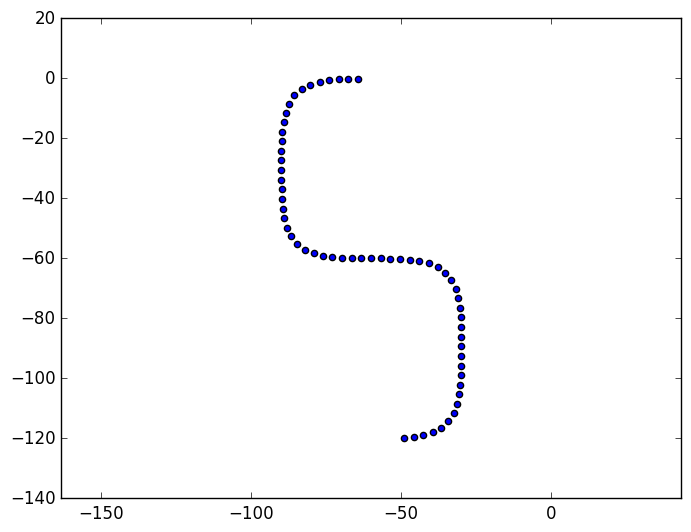

In [47]:
PyPlot.scatter(xP[21:81],yP[21:81])
PyPlot.axis("equal")
PyPlot.show()

In [55]:
xP[1],xP[end],xP[end-1],xP[end-2]

(0.0,3.2133226102201524,6.426645220440472,9.639967830660774)